In [ ]:
# This notebook has been run on Google Colab. To run it, uncomment the following lines

# !rm -r Few-shot-learning-with-HuBERT
# !git clone -b add-fewshot-urban --single-branch \
# https://github.com/luckyman94/Few-shot-learning-with-HuBERT.git

# !pip install -U kagglehub

# !rm -r kagglehub_cache/


Cloning into 'Few-shot-learning-with-HuBERT'...
remote: Enumerating objects: 133, done.
remote: Counting objects: 100% (133/133), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 133 (delta 46), reused 119 (delta 32), pack-reused 0 (from 0)
Receiving objects: 100% (133/133), 1.01 MiB | 17.75 MiB/s, done.
Resolving deltas: 100% (46/46), done.
rm: cannot remove 'kagglehub_cache/': No such file or directory


In [ ]:

import os
import sys
from pathlib import Path
import torch

# ---- Hugging Face token ----
# Uncomment the following line if you want to run the notebook on Google Colab. Make sure to replace "YOUR
#os.environ["HF_TOKEN"] = "YOUR TOKEN HERE"

# Uncomment the following lines if you want to run the notebook on Google Colab
#ROOT = Path.cwd() / "Few-shot-learning-with-HuBERT"
#sys.path.append(str(ROOT))

assert "HF_TOKEN" in os.environ
project_root = Path().resolve().parent
sys.path.append(str(project_root))



# ---- Project imports ----
from transformers import HubertModel

from src.datasets.crema import CremaDDataset
from src.methods.fewshot.benchmark import benchmark_fewshot
from src.evaluation.evaluate import evaluate_benchmark
from src.methods.fewshot.sampling import sample_task
from src.methods.fewshot.prototypical import compute_prototypes, classify

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Example : 1 experiment

In [26]:
dataset = CremaDDataset()

print("Classes :", dataset.classes)
print("Nombre total de fichiers :", len(dataset))

x, y = dataset[0]
print(x.shape, y)



Using Colab cache for faster access to the 'cremad' dataset.
Classes : ['angry', 'disgust', 'fearful', 'happy', 'neutral', 'sad']
Nombre total de fichiers : 7442
torch.Size([24000]) 1


In [27]:
from tqdm import tqdm
import torch

X = []
y = []

for waveform, label in tqdm(dataset, desc="Loading dataset"):
    X.append(waveform)
    y.append(label)

X = torch.stack(X)
y = torch.tensor(y)

print("X shape:", X.shape)
print("y shape:", y.shape)


Loading dataset: 100%|██████████| 7442/7442 [01:42<00:00, 72.94it/s]


X shape: torch.Size([7442, 24000])
y shape: torch.Size([7442])


In [28]:
X_support, y_support, X_query, y_query = sample_task(
    X,
    y,
    n_way=10,
    k_shot=1,
    n_query=20
)


In [29]:
hubert = HubertModel.from_pretrained("facebook/hubert-base-ls960", use_safetensors=True)
hubert.eval().to(device)

for p in hubert.parameters():
    p.requires_grad = False

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/211 [00:00<?, ?it/s]

In [30]:
prototypes, proto_labels = compute_prototypes(
    hubert, X_support, y_support, device=device
)

preds = classify(
    hubert, X_query, prototypes, proto_labels, device=device
)

acc = (preds.cpu() == y_query).float().mean()
print("Few-shot accuracy:", acc.item())


Few-shot accuracy: 0.25833332538604736


## Benchmark

In [31]:
results = {}
for k in [1,5,10]:
    results[k] = benchmark_fewshot(model=hubert, X=X, y=y, device=device, k_shot=k, n_tasks=10)


10-shot benchmark: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]



===== Few-shot evaluation summary =====

--- 1-shot ---
Accuracy : 0.2400 ± 0.0326
F1 macro : 0.2385


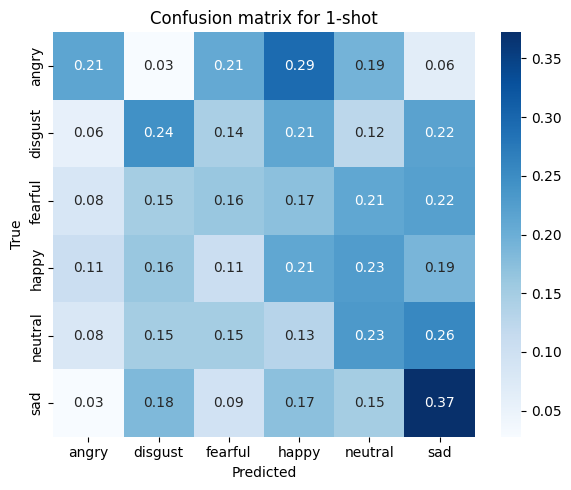


=== Evaluation metrics ===
accuracy    : 0.2400
f1_macro    : 0.2385
precision_macro: 0.2451
recall_macro: 0.2390


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


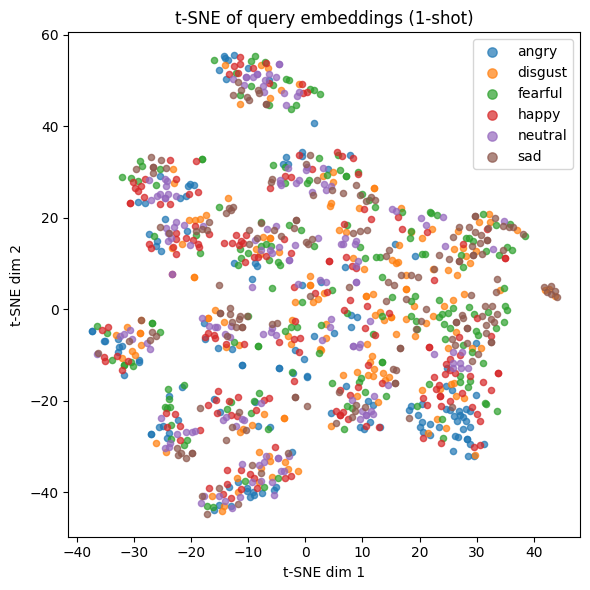


--- 5-shot ---
Accuracy : 0.3440 ± 0.0436
F1 macro : 0.3462


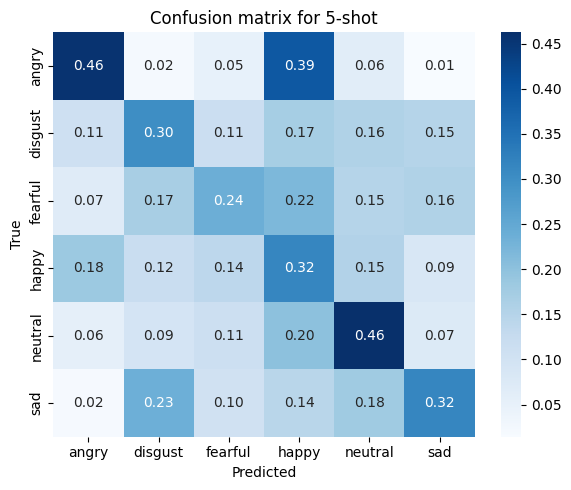


=== Evaluation metrics ===
accuracy    : 0.3440
f1_macro    : 0.3462
precision_macro: 0.3520
recall_macro: 0.3479


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


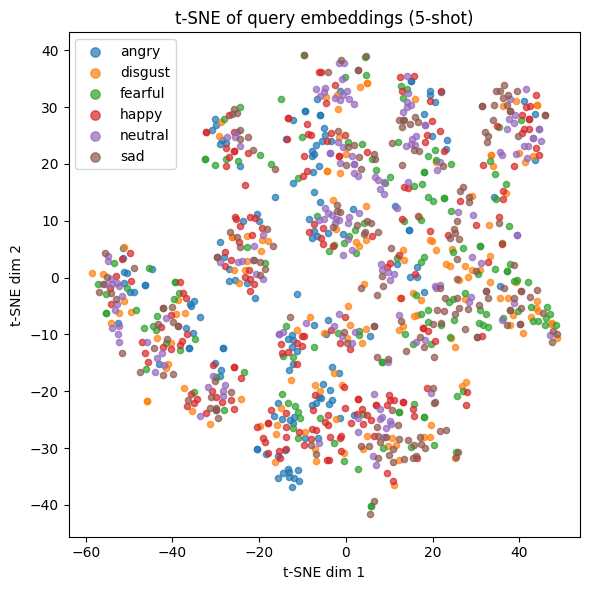


--- 10-shot ---
Accuracy : 0.3720 ± 0.0456
F1 macro : 0.3581


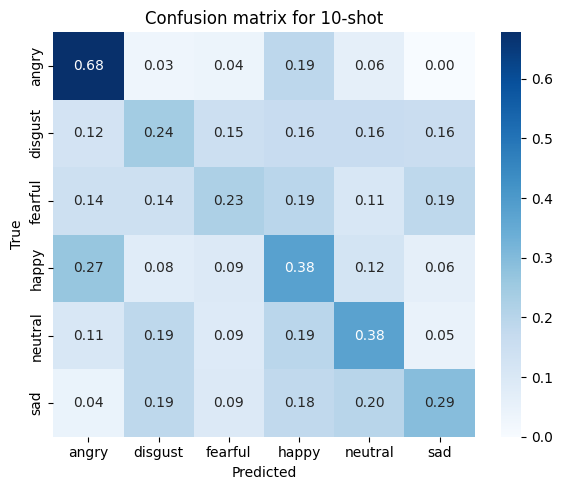


=== Evaluation metrics ===
accuracy    : 0.3720
f1_macro    : 0.3581
precision_macro: 0.3607
recall_macro: 0.3655


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


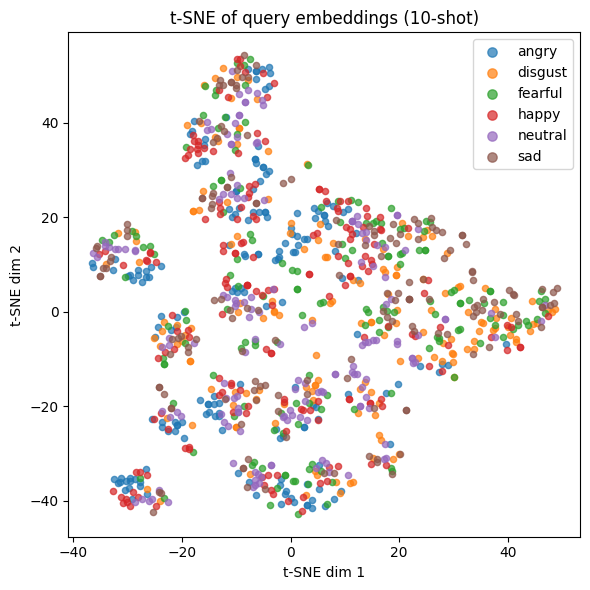

In [32]:
evaluate_benchmark(results, class_names=dataset.classes)